In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import norm
from scipy.stats import gamma
%matplotlib inline

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pd.read_csv('./../data/clean_data.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df['type'].value_counts()

tx         973640
call       492595
create      27726
suicide       318
Name: type, dtype: int64

In [5]:
df['newContract'].value_counts()

0    1489351
1       4928
Name: newContract, dtype: int64

In [6]:
for col in df.columns:
    print(col, df[col].isnull().sum())

hash_t 0
accountNonce 0
amount 0
block_id 0
gasLimit_t 0
gasUsed_t 0
newContract 0
price 0
time_t 0
type 0
blockTime 0
difficulty 0
gasLimit_b 0
gasUsed_b 0
reward 0
size 0
time_b 0
totalFee 0
tx_count 0
uncle_count 0
price_gwei 0
amount_gwei 0
gasShare 0
gweiPaid 0
gweiPaid_b 0
gweiShare 2
free_t 0
day 0
hour 0
dayofweek 0


In [7]:
df.drop('mixDigest', axis=1, inplace=True)

ValueError: labels ['mixDigest'] not contained in axis

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(1494277, 30)

In [10]:
df.head()

,hash_t,accountNonce,amount,block_id,gasLimit_t,gasUsed_t,newContract,price,time_t,type,...,price_gwei,amount_gwei,gasShare,gweiPaid,gweiPaid_b,gweiShare,free_t,day,hour,dayofweek
0,0xfc505bf23efe13154192262c3f7b99e2517b133fe5f6...,3324654,499093201921000000,4295887,50000,21000,0,21000000000,2017-09-20 20:24:15,tx,...,21.0,4.990932e+08,0.054830,441000.0,8627577.0,0.051115,0,20,20,2
1,0xfa0124a64e4cedc7d75dff3ee0fca13d32b2a368e0cb...,3324658,149222093810000000,4295887,20967,9416,0,21000000000,2017-09-20 20:24:15,call,...,21.0,1.492221e+08,0.024585,197736.0,8627577.0,0.022919,0,20,20,2
2,0xe2a23b916903133728ab3dbfac55a56651508a971e89...,3324660,99608460653500000,4295887,50000,21000,0,21000000000,2017-09-20 20:24:15,tx,...,21.0,9.960846e+07,0.054830,441000.0,8627577.0,0.051115,0,20,20,2
3,0xc431fcd82ad55dc1aee932fa9965b55f8515981147a0...,3324657,199004777431000000,4295887,50000,21000,0,21000000000,2017-09-20 20:24:15,tx,...,21.0,1.990048e+08,0.054830,441000.0,8627577.0,0.051115,0,20,20,2
4,0xb759c34cb5b5af6f94f7002ef812b8482880d1f73d10...,3324662,1000288571660000000,4295887,50000,21000,0,21000000000,2017-09-20 20:24:15,tx,...,21.0,1.000289e+09,0.054830,441000.0,8627577.0,0.051115,0,20,20,2


In [11]:
# drop cases where gasUsed_t is zero since no gas was used
print('exclude {} rows with zero gas used'.format(df[df['gasUsed_t'] == 0].values.shape[0]))

exclude 89799 rows with zero gas used


In [12]:
df = df[df['gasUsed_t'] != 0]

## Generate new columns with average block info
### Take average values over two time horizons
- 6 blocks (~1 min) -> represents the current state (short frequency view)
- 60 blocks (~10 min) -> represents the long term view

In [13]:
df['txcnt_second'] = df['tx_count'].values / df['blockTime'].values
df['avg_gasUsed_t_perblock'] = df.groupby('block_id')['gasUsed_t'].transform('mean')
df['avg_price_perblock'] = df.groupby('block_id')['price_gwei'].transform('mean')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [14]:
def rolling_avg(window_size):
    
    price = df[['block_id', 'avg_price_perblock']].drop_duplicates().sort_values(
                        'block_id', ascending=True)
    
    gasUsed_t = df[['block_id', 'avg_gasUsed_t_perblock']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    txcnt_second = df[['block_id', 'txcnt_second']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    tx_count = df[['block_id', 'tx_count']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    gasUsed_b = df[['block_id', 'gasUsed_b']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    uncle_count = df[['block_id', 'uncle_count']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    difficulty = df[['block_id', 'difficulty']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    blocktime = df[['block_id', 'blockTime']].drop_duplicates().sort_values(
                             'block_id', ascending=True)
    
    # create new pandas dataframe with average values
    rolling_avg = pd.DataFrame()
    
    # calculate rolling averages 
    rolling_avg['avg_blocktime'] = blocktime['blockTime'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_b'] = gasUsed_b['gasUsed_b'].rolling(window=window_size).mean()
    rolling_avg['avg_tx_count'] = tx_count['tx_count'].rolling(window=window_size).mean()
    rolling_avg['avg_uncle_count'] = uncle_count['uncle_count'].rolling(window=window_size).mean()
    rolling_avg['avg_difficulty'] = difficulty['difficulty'].rolling(window=window_size).mean()
    rolling_avg['avg_txcnt_second'] = txcnt_second['txcnt_second'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_t'] = gasUsed_t['avg_gasUsed_t_perblock'].rolling(window=window_size).mean()
    rolling_avg['avg_price'] = price['avg_price_perblock'].rolling(window=window_size).mean()
    
    # insert blockids to merge on
    rolling_avg['blockids'] = df['block_id'].drop_duplicates().sort_values(ascending=True)
    
    return rolling_avg

In [15]:
num_blocks = [6, 60]
for num in num_blocks:
    df_rolling_avg = rolling_avg(num)
    df_rolling_avg.to_csv('./../data/block_avg_{}.csv'.format(num))

In [16]:
df_rolling_avg_6 = rolling_avg(6)

In [17]:
df_rolling_avg_60 = rolling_avg(60)

## Merge data with new columns

In [18]:
merged1 = pd.merge(df, df_rolling_avg_6, left_on='block_id', right_on='blockids')

In [19]:
merged2 = pd.merge(merged1, df_rolling_avg_60, left_on='block_id', right_on='blockids', suffixes=('_6', '_60'))

In [20]:
merged2.columns

Index([u'hash_t', u'accountNonce', u'amount', u'block_id', u'gasLimit_t',
       u'gasUsed_t', u'newContract', u'price', u'time_t', u'type',
       u'blockTime', u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward',
       u'size', u'time_b', u'totalFee', u'tx_count', u'uncle_count',
       u'price_gwei', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_gasUsed_t_perblock', u'avg_price_perblock', u'avg_blocktime_6',
       u'avg_gasUsed_b_6', u'avg_tx_count_6', u'avg_uncle_count_6',
       u'avg_difficulty_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'blockids_6', u'avg_blocktime_60', u'avg_gasUsed_b_60',
       u'avg_tx_count_60', u'avg_uncle_count_60', u'avg_difficulty_60',
       u'avg_txcnt_second_60', u'avg_gasUsed_t_60', u'avg_price_60',
       u'blockids_60'],
      dtype='object')

In [21]:
for col in merged2.columns:
    print(col, merged2[col].isnull().sum())

hash_t 0
accountNonce 0
amount 0
block_id 0
gasLimit_t 0
gasUsed_t 0
newContract 0
price 0
time_t 0
type 0
blockTime 0
difficulty 0
gasLimit_b 0
gasUsed_b 0
reward 0
size 0
time_b 0
totalFee 0
tx_count 0
uncle_count 0
price_gwei 0
amount_gwei 0
gasShare 0
gweiPaid 0
gweiPaid_b 0
gweiShare 0
free_t 0
day 0
hour 0
dayofweek 0
txcnt_second 0
avg_gasUsed_t_perblock 0
avg_price_perblock 0
avg_blocktime_6 1003
avg_gasUsed_b_6 1003
avg_tx_count_6 1003
avg_uncle_count_6 1003
avg_difficulty_6 1003
avg_txcnt_second_6 1003
avg_gasUsed_t_6 1003
avg_price_6 1003
blockids_6 0
avg_blocktime_60 7852
avg_gasUsed_b_60 7852
avg_tx_count_60 7852
avg_uncle_count_60 7852
avg_difficulty_60 7852
avg_txcnt_second_60 7852
avg_gasUsed_t_60 7852
avg_price_60 7852
blockids_60 0


In [22]:
merged2.dropna(inplace=True)

# Create a label
- What are we predicting? 
- A hindsight estimate of what the price should be, given knowledge about previous blocks
- Develop a summary statistic about the distribution of prices over previous blocks
- Our target: the 25th percentile of the distribution (gweiShare / gasShare)

## Definitions
- gasUsed_t -> the amount of gas consumed on a transation
- gasUsed_b -> the amount of gas consumed in an entire block
- gweiPaid -> the total amount paid (Gwei) for a transaction (= gasUsed_t x price_gwei)
- gweiPaid_b -> the total amount paid in a block 
- gweiShare -> the fraction of gwei paid w.r.t. the entire block
- gasShare -> the fraction of gas consumed w.r.t. the entire block

## Define "miner value" – mv
- the fraction of prices per block and gas per block
- mv = gweiShare / gasShare 
- local parameter (per transaction)

## Define mu
- mu is a summary statistic of mv (global parameter)
- a measure of how likely a transaction is to be "picked up" by a miner for completion (risk factor)
- our target/goal is for mu to be the 25th percentile of mv (gweiShare / gasShare)
- mu = percentile(mv, 25) over the entire distribution of mv values
- we can tune this parameter to increase or decrease the desired percentile 
- it is a pre-emptive statistical calculation based on our hindsight knowledge

## The "price" predicted with hindsight 
- knowing mu, how do we obtain our hindsight recommendation?
- using our definition of mu, we solve an equation to obtain p (price)
- p = (mu x gweiPaid_b) / gasUsed_b
- this will serve as our label and thus recommendation for how much to pay per unit gas for a transation to successfully commence 
- it tells us what price we need to set in order to force mv for that bid to be mu

## Calculate miner value (mv) for every datapoint in our dataset
- price / gas or gweiShare / gasShare

In [23]:
merged2['mv'] = merged2.gweiShare / merged2.gasShare

In [24]:
merged2['mv'].isnull().sum()

0

In [25]:
merged2['mv'].describe()

count    1.396626e+06
mean     1.630020e+00
std      4.529158e+00
min      5.990722e-11
25%      7.314627e-01
50%      1.180220e+00
75%      1.909421e+00
max      4.233297e+03
Name: mv, dtype: float64

## Compute the summary statistic mu
- given the distribution of mv values, fit a statistical model to the data
- use this fit model to compute the 25th percentile of the distribution

In [26]:
alpha = .25
mu= merged2.mv.quantile(alpha)

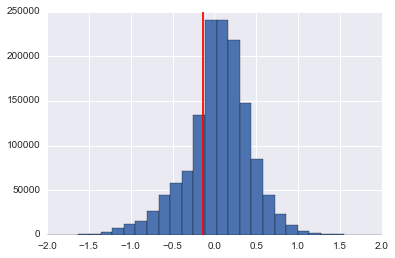

In [27]:
merged2.mv.apply(np.log10).hist(bins=100)
plt.xlim([-2,2])
ylims=plt.gca().get_ylim()
plt.vlines(np.log10(mu), ylims[0], ylims[1], 'r' )

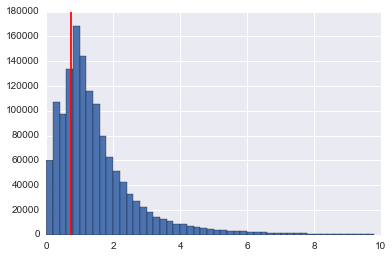

In [28]:
merged2.mv.hist(bins=np.arange(0,10,.20))
ylims=plt.gca().get_ylim()
plt.vlines(mu, ylims[0], ylims[1], 'r' )

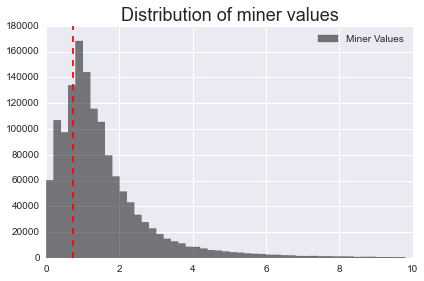

In [29]:
merged2.mv.hist(bins=np.arange(0,10,.20), color = 'k', alpha=0.5, histtype='stepfilled', 
                label='Miner Values')
ylims=plt.gca().get_ylim()
plt.vlines(mu, ylims[0], ylims[1], 'r', linestyle='--')
plt.title('Distribution of miner values', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('./../images/mv_dist.png', dpi=300)

# Compute the label, p, given mu
- knowing mu, how do we obtain our hindsight recommendation?
- using our definition of mu, we solve an equation to obtain p (price)
- p = (mu x gweiPaid_b) / gasUsed_b
- this will serve as our label and thus recommendation for how much to pay per unit gas for a transation to successfully commence 
- it tells us what price we need to set in order to force mv for that bid to be mu

In [30]:
mu

0.7314626987914776

In [31]:
merged2['p_label'] = mu* (merged2.gweiPaid_b / merged2.gasUsed_b)

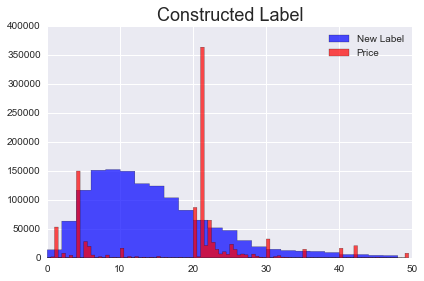

In [32]:
merged2['p_label'].hist(bins=np.arange(0,50,2), color = 'b', alpha=0.7, histtype='stepfilled',
                        label='New Label')
merged2['price_gwei'].hist(bins=np.arange(0,50,.5), color = 'r', alpha=0.7, 
                           histtype='stepfilled', label='Price')
plt.title('Constructed Label', fontsize=18)
plt.legend()
plt.tight_layout()

In [33]:
merged2['p_label2'] = mu*merged2.gweiPaid_b/(merged2.gasUsed_b+merged2.gasUsed_t*(1-mu))

In [34]:
merged2.p_label2.describe()

count    1.396626e+06
mean     1.607988e+01
std      3.145145e+01
min      4.313397e-03
25%      8.039027e+00
50%      1.279935e+01
75%      1.898114e+01
max      2.158104e+03
Name: p_label2, dtype: float64

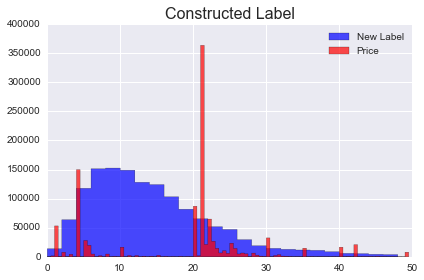

In [35]:
merged2['p_label2'].hist(bins=np.arange(0,50,2), color = 'b', alpha=0.7, histtype='stepfilled',
                         label='New Label')
merged2['price_gwei'].hist(bins=np.arange(0,50,.5), color = 'r', alpha=0.7, histtype='stepfilled',
                           label='Price')
plt.title('Constructed Label', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('./../images/label.png', dpi=300)

Look our method smoothed the prices out!

## Write training set and labels to a csv file for modeling

In [36]:
merged2.columns

Index([u'hash_t', u'accountNonce', u'amount', u'block_id', u'gasLimit_t',
       u'gasUsed_t', u'newContract', u'price', u'time_t', u'type',
       u'blockTime', u'difficulty', u'gasLimit_b', u'gasUsed_b', u'reward',
       u'size', u'time_b', u'totalFee', u'tx_count', u'uncle_count',
       u'price_gwei', u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b',
       u'gweiShare', u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_gasUsed_t_perblock', u'avg_price_perblock', u'avg_blocktime_6',
       u'avg_gasUsed_b_6', u'avg_tx_count_6', u'avg_uncle_count_6',
       u'avg_difficulty_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'blockids_6', u'avg_blocktime_60', u'avg_gasUsed_b_60',
       u'avg_tx_count_60', u'avg_uncle_count_60', u'avg_difficulty_60',
       u'avg_txcnt_second_60', u'avg_gasUsed_t_60', u'avg_price_60',
       u'blockids_60', u'mv', u'p_label', u'p_label2'],
      dtype='object')

In [37]:
# select candidate features for modeling
sel_cols = ['gasLimit_t',
           'gasUsed_t',
           'newContract',
           'blockTime',
           'difficulty',
           'gasLimit_b',
           'gasUsed_b',
           'reward',
           'size',
           'type',
           'totalFee',
           'amount_gwei',
           'gasShare',
           'gweiPaid',
           'gweiPaid_b',
           'gweiShare',
           'free_t',
           'day',
           'hour',
           'dayofweek',
           'txcnt_second',
           'avg_blocktime_6',
           'avg_gasUsed_b_6',
           'avg_tx_count_6', 
           'avg_uncle_count_6',
           'avg_difficulty_6',
           'avg_txcnt_second_6',
           'avg_gasUsed_t_6',
           'avg_price_6', 
           'avg_blocktime_60',
           'avg_gasUsed_b_60',
           'avg_tx_count_60',
           'avg_uncle_count_60',
           'avg_difficulty_60',
           'avg_txcnt_second_60',
           'avg_gasUsed_t_60',
           'avg_price_60',
           'mv']

In [38]:
features = merged2[sel_cols]

In [39]:
features.to_csv('./../data/training.csv')

In [40]:
labels = merged2['p_label2']

In [41]:
labels.to_csv('./../data/labels.csv')